In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import itertools
import matplotlib.pyplot as plt

from scipy import stats
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, Trials

In [2]:
ds = pd.read_excel(r'RETAIL.xlsx', decimal=',')

df = pd.DataFrame(ds, columns=['date', 'sales'])

month_dict = {'Янв': 1, 'Фев': 2, 'Мар': 3, 'Апр': 4, 'Май': 5, 'Июн': 6, 'Июл': 7, 'Авг': 8, 'Сен': 9, 'Окт': 10, 'Ноя': 11, 'Дек': 12}
df['date'] = df['date'].apply(lambda x: pd.to_datetime(f"{month_dict[x.split('-')[0]]}-{x.split('-')[1]}"))

df.to_excel('data.xlsx')

df

,date,sales
0,1967-01-01,1697
1,1967-02-01,1599
2,1967-03-01,1765
3,1967-04-01,1803
4,1967-05-01,1891
...,...,...
404,2000-09-01,18901
405,2000-10-01,18856
406,2000-11-01,17856
407,2000-12-01,17647


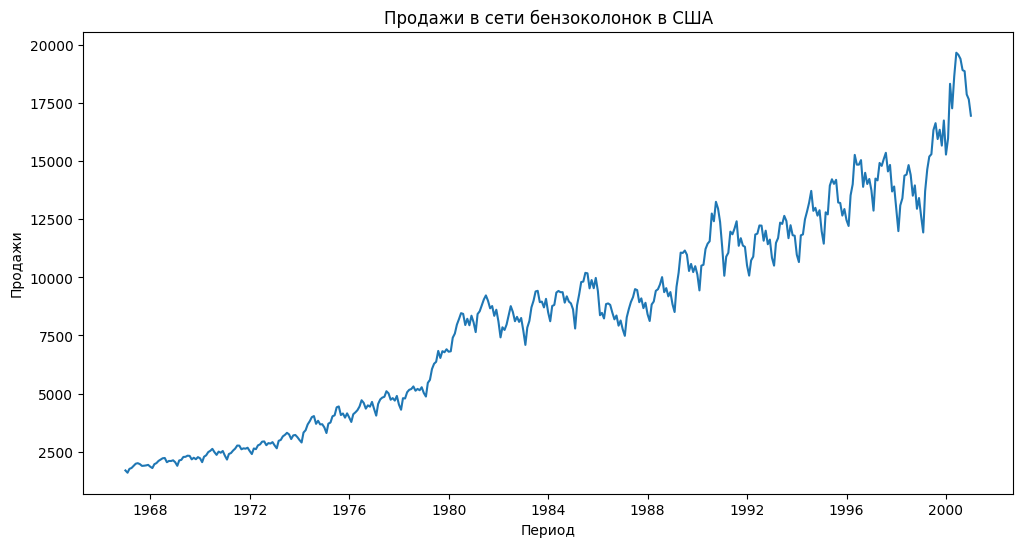

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'],df['sales'])
plt.title('Продажи в сети бензоколонок в США')
plt.xlabel('Период')
plt.ylabel('Продажи')
plt.show()

In [4]:
result = adfuller(df['sales'])
print('ADF статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: 0.7153238269202791
p-значение: 0.9901387734678274
Критические значения:
  1%: -3.4472291365835566
  5%: -2.8689795375849223
  10%: -2.5707330834976987


In [5]:
df['log_sales'] = np.log(df['sales'])

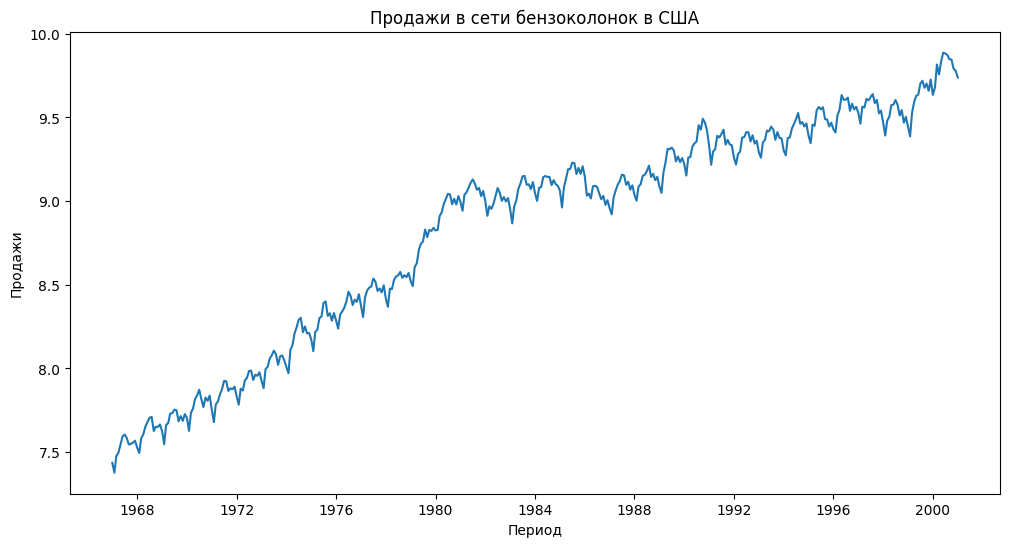

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['log_sales'])
plt.title('Продажи в сети бензоколонок в США')
plt.xlabel('Период')
plt.ylabel('Продажи')
plt.show()

In [7]:
result = adfuller(df['log_sales'])
print('ADF статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: -1.3063440831044684
p-значение: 0.6262649129232958
Критические значения:
  1%: -3.447014064067954
  5%: -2.8688850015516016
  10%: -2.5706826870693797


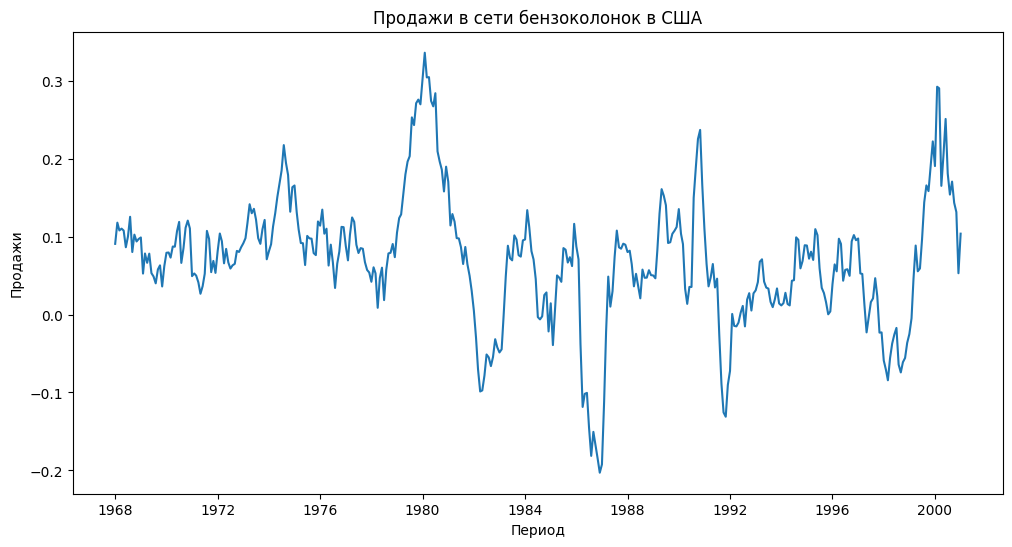

In [8]:
df['time_series_diff_1'] = df['log_sales'] - df['log_sales'].shift(12)

df.dropna(inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['time_series_diff_1'])
plt.title('Продажи в сети бензоколонок в США')
plt.xlabel('Период')
plt.ylabel('Продажи')
plt.show()

In [9]:
result = adfuller(df['time_series_diff_1'])
print('ADF статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: -3.106534499240154
p-значение: 0.02607337050480857
Критические значения:
  1%: -3.4474946672686824
  5%: -2.8690962436986855
  10%: -2.570795299750434


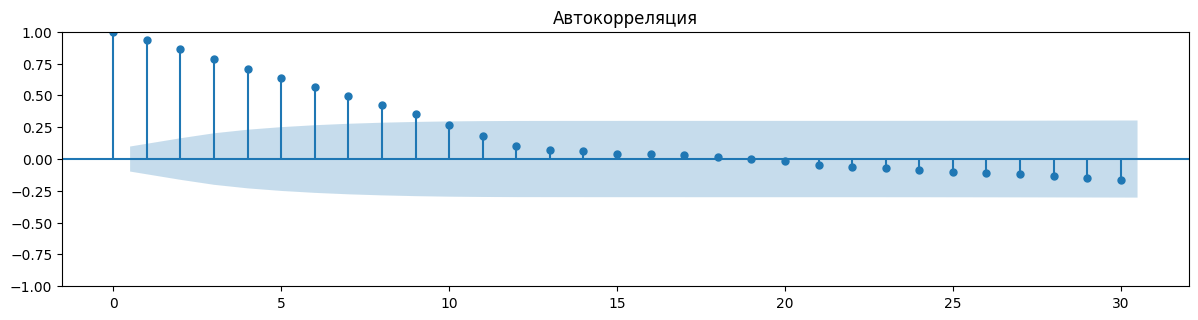

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df['time_series_diff_1'], lags=30, ax=plt.gca())
plt.title('Автокорреляция')
plt.tight_layout()
plt.show()

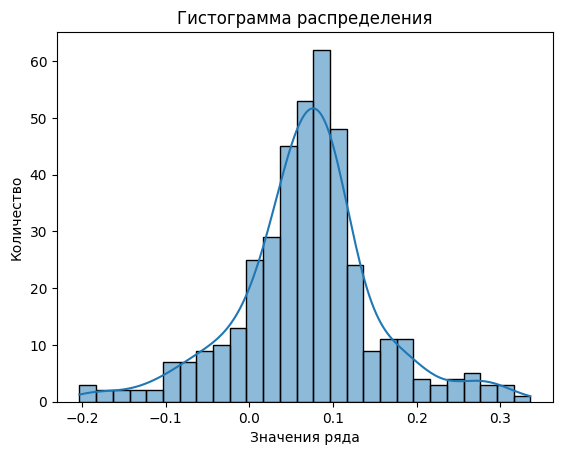

In [11]:
sns.histplot(df['time_series_diff_1'], kde='norm')
plt.xlabel('Значения ряда')
plt.ylabel('Количество')
plt.title('Гистограмма распределения')
plt.show()

In [12]:
print('Математическое ожидание:',df['time_series_diff_1'].mean())

Математическое ожидание: 0.06897150331314814


In [14]:
print('Дисперсия временного ряда:',df['time_series_diff_1'].var())

Дисперсия временного ряда: 0.006858571209970251


In [15]:
%%time
p = range(0,10)
d = range(0,3)
q = range(0,3)

pdq = list(itertools.product(p, d, q))
best_pdq = (0,0,0)
best_bic = np.inf

for params in pdq:
    model_test = ARIMA(df['sales'], order = params)
    result_test = model_test.fit()
    
    if result_test.bic < best_bic:
        best_pdq = params
        best_bic = result_test.bic
    
p, d, q = best_pdq

print(f'Порядок авторегресии: {p}\nПорядок дифференцирования: {d}\nПорядок скользящего среднего: {q}')
print(f'Наилучшее значение BIC: {best_bic}')

c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

Порядок авторегресии: 8
Порядок дифференцирования: 1
Порядок скользящего среднего: 2
Наилучшее значение BIC: 5795.49641729823
CPU times: total: 1min 56s
Wall time: 33 s


c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [16]:
model = ARIMA(df['sales'], order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  397
Model:                 ARIMA(8, 1, 2)   Log Likelihood               -2864.850
Date:                Sat, 14 Dec 2024   AIC                           5751.701
Time:                        18:41:11   BIC                           5795.496
Sample:                             0   HQIC                          5769.051
                                - 397                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1364      0.060    -19.000      0.000      -1.254      -1.019
ar.L2         -0.6329      0.077     -8.237      0.000      -0.783      -0.482
ar.L3          0.0773      0.075      1.035      0.3

c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


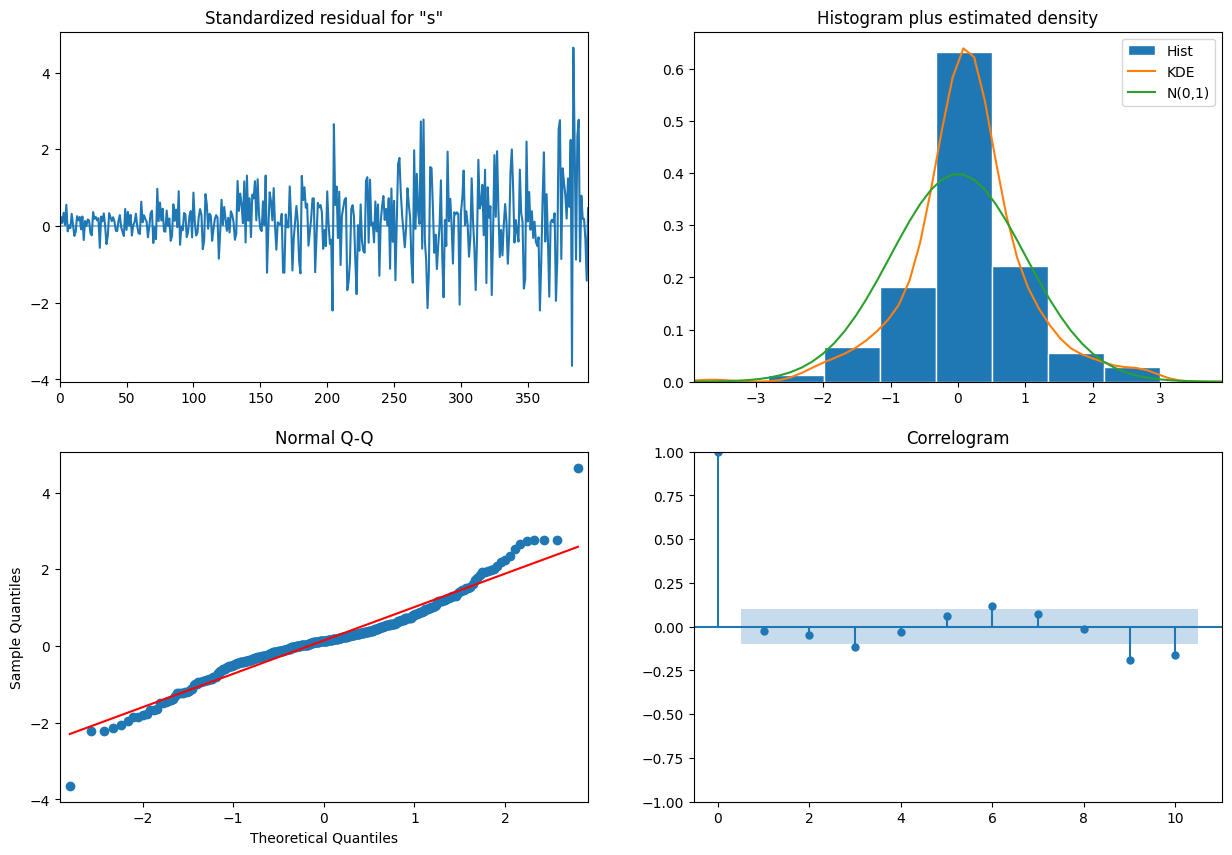

In [17]:
model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()

c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Morzhig\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


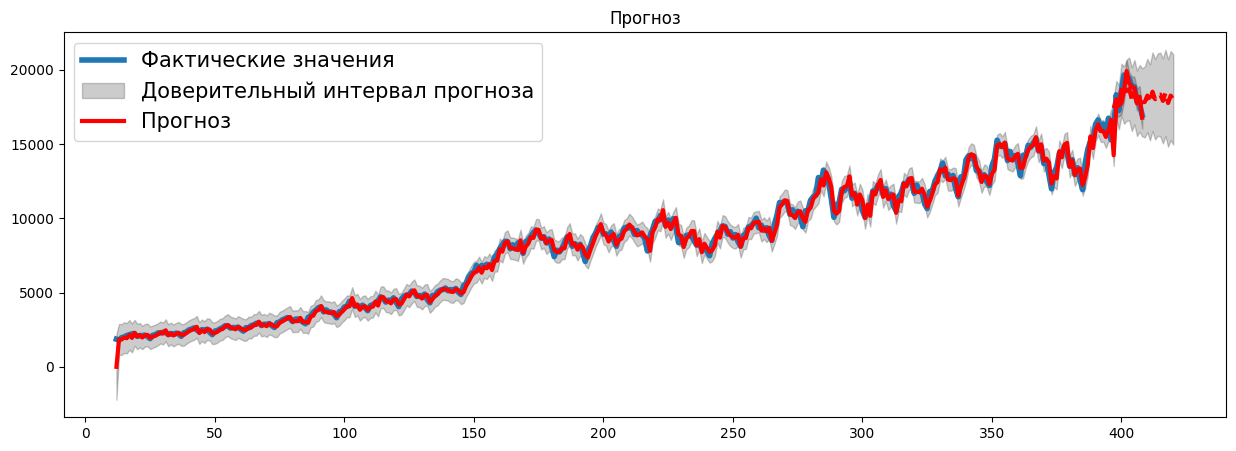

In [18]:
forecast = model_fit.get_prediction()
forecast_ci = forecast.conf_int()

plt.figure(figsize=(15,5))

plt.plot(df['sales'], label="Фактические значения", linewidth=4)
plt.fill_between(forecast_ci.index,
forecast_ci.iloc[:, 0],
forecast_ci.iloc[:, 1], color='k', alpha=.2, label='Доверительный интервал прогноза')
plt.plot(forecast.predicted_mean, color='red', label="Прогноз", linewidth=3)

forecast = model_fit.get_forecast(steps=24)
plt.plot(forecast.predicted_mean, color='red', linestyle='dashed', linewidth=3)
forecast_ci = forecast.conf_int()
plt.fill_between(forecast_ci.index,
forecast_ci.iloc[:, 0],
forecast_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend(fontsize=15)

plt.title('Прогноз')

plt.show()

In [ ]:
forecast = model_fit.predict()

mse = mean_squared_error(df['sales'], forecast)

print(f'MSE: {mse}')

MSE: 116377.66874069531


In [ ]:
%%time
def arima_objective_function(params):
    global data_values
    
    p, d, q = params
    
    try:
        model = ARIMA(data_values, order=(p, d, q))
        predictions = model.fit()
        y_pred = predictions.predict()
        mse = mean_squared_error(data_values, y_pred)
    except:
        mse = float('inf')
    
    return mse

param_space = [hp.choice('p', range(0, 30)), hp.choice('d', range(0, 30)), hp.choice('q', range(0, 30))]

data_values = df['sales']

trials = Trials()
best = fmin(fn=arima_objective_function, space=param_space, algo=tpe.suggest, max_evals=100, trials=trials)

In [ ]:
print(best)
best_loss = trials.best_trial['result']['loss']
print('best loss:', best_loss)

In [ ]:
p, d, q = 

model = ARIMA(data_values, order=(p, d, q))

forecast = model_fit.get_prediction()
forecast_ci = forecast.conf_int()

plt.figure(figsize=(15,5))

plt.plot(df['sales'], label="Фактические значения", linewidth=4)
plt.fill_between(forecast_ci.index,
forecast_ci.iloc[:, 0],
forecast_ci.iloc[:, 1], color='k', alpha=.2, label='Доверительный интервал прогноза')
plt.plot(forecast.predicted_mean, color='red', label="Прогноз", linestyle='dashed', linewidth=3)

forecast = model_fit.get_forecast(steps=24)
plt.plot(forecast.predicted_mean, color='red', linestyle='dashed', linewidth=3)
forecast_ci = forecast.conf_int()
plt.fill_between(forecast_ci.index,
forecast_ci.iloc[:, 0],
forecast_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend(fontsize=15)

plt.title('Прогноз')

plt.show()

In [ ]:
losses = [trial['result']['loss'] for trial in trials.trials]
best_losses = [min(losses[:i+1]) for i in range(len(losses))]

plt.plot(range(1, len(losses)+1), best_losses)
plt.xlabel('Итерации')
plt.ylabel('MSE')
plt.title('Уменьшение MSE')
plt.show()